# Intro
The Hand Gesture Recognition Database is a collection of near-infra-red images of ten distinct hand gestures. I

 

In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting


As described in the Data Overview, there are 10 folders labelled 00 to 09, each containing images from a given subject. In each folder there are subfolders for each gesture. We'll build a dictionary `lookup` storing the names of the gestures we need to identify, and giving each gesture a numerical identifier. We'll also build a dictionary `reverselookup` that tells us what gesture is associated to a given identifier.

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('/home/nasir/Desktop/AI Q3/FYP/Dataset/archive(2)/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'03_fist': 0,
 '05_thumb': 1,
 '01_palm': 2,
 '04_fist_moved': 3,
 '07_ok': 4,
 '06_index': 5,
 '09_c': 6,
 '08_palm_moved': 7,
 '02_l': 8,
 '10_down': 9}

Next we read in the images, storing them in `x_data`. We store the numerical classifier for each image in `y_data`.

In [3]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 1): # Loop over the ten top-level folders
    for j in os.listdir('/home/nasir/Desktop/AI Q3/FYP/Dataset/archive(2)/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('/home/nasir/Desktop/AI Q3/FYP/Dataset/archive(2)/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('/home/nasir/Desktop/AI Q3/FYP/Dataset/archive(2)/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

Let's take a look at some of the pictures. 

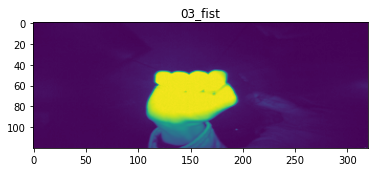

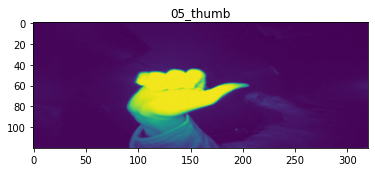

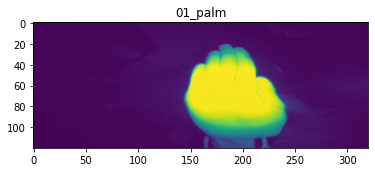

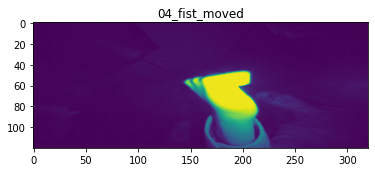

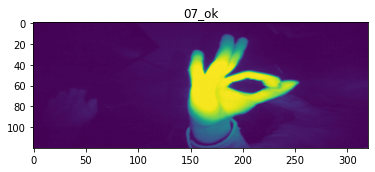

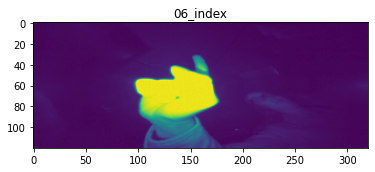

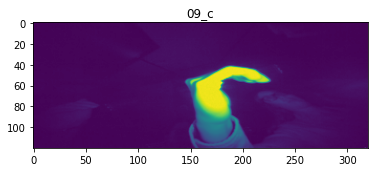

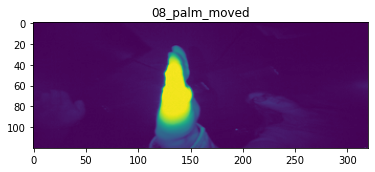

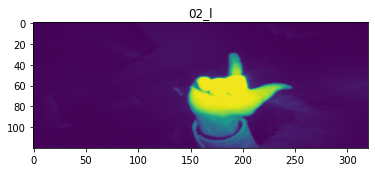

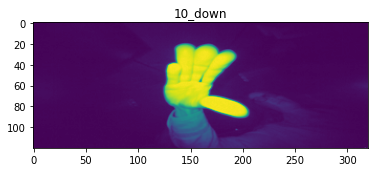

In [4]:
from random import randint
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()


n order to convert it to one-hot format, we use the keras function to_categorical:

In [5]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

Our set of images has shape `(datacount, 120, 320)`. Keras will be expecting another slot to tell it the number of channels, so we reshape `x_data` accordingly. We also rescale the values in `x_data` to lie between 0 and 1.

In [6]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

We need a cross-validation set and a test set, and we'll use the `sklearn` package to construct these. In order to get an 80-10-10 split, we call `train_test_split` twice, first to split 80-20, then to split the smaller chunk 50-50. Note that we do this after the rescaling step above, to ensure that our train and test sets are coming from the same distribution.

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)



#x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

To build our network. We'll use keras.

In [8]:
from keras import layers
from keras import models

We won't worry about padding since it's clear that all the useful features are well inside the image. We'll continue with a sequence of convolutional layers followed by max-pooling until we arrive at a small enough image that we can add a fully-connected layer. Since we need to classify between 10 possibilities, we finish with a softmax layer with 10 neurons. 

In [9]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 158, 32)       832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0

Finally, we fit the model.

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

25/25 [==============================] - 61s 2s/step - loss: 0.3121 - accuracy: 0.9707 - val_loss: 0.0019 - val_accuracy: 1.0000


At this point we would typically graph the accuracy of our model on the validation set, and choose a suitable number of epochs to train for to avoid overfitting. We might also consider introducing dropout and regularisation. However, we can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [14]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

7/7 [==============================] - 2s 306ms/step - loss: 0.0012 - accuracy: 1.0000
Accuracy:1.0


You'll get slightly different numbers each time you run it but you should be getting between 99.9 and 100% accuracy. Great!

In [20]:
model.save('gestures_trained_cnn_model.h5')

# Attempting to use Laptops Webcam to Predict model

In [29]:
import cv2
import numpy as np
from keras import models
import sys
from PIL import Image#Load the saved model
#model = keras.models.load_model('./Desktop/AI Q3/FYP/gestures_trained_cnn_model.h5')# Start capturing Video through webcam
video = cv2.VideoCapture(0)

In [ ]:
while True:
    _, frame = video.read()
    kernel = np.ones((3,3),np.uint8)
     
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)# define range of skin color in HSV
    lower_skin = np.array([0,20,70], dtype=np.uint8)
    upper_skin = np.array([20,255,255], dtype=np.uint8)#extract skin colur image
    mask = cv2.inRange(hsv, lower_skin, upper_skin)#extrapolate the hand to fill dark spots within
    mask = cv2.dilate(mask,kernel,iterations = 4)#blur the image
    mask = cv2.GaussianBlur(mask,(5,5),100)
    mask = cv2.resize(mask,(128,128))
    img_array = np.array(mask)
    #print(img_array.shape)# Changing dimension from 128x128 to 128x128x3
    img_array = np.stack((img_array,)*3, axis=-1)
    #Our keras model used a 4D tensor, (images x height x width x channel)
    #So changing dimension 128x128x3 into 1x128x128x3 
    img_array_ex = np.expand_dims(img_array, axis=0)
    print(img_array_ex.shape)
    #Calling the predict method on model to predict gesture in the frame
    prediction = model.predict(img_array_ex)
    print(prediction)
    cv2.imshow("Capturing", frame)
    key=cv2.waitKey(1)
    if key == ord('q'):
        break
video.release()
cv2.destroyAllWindows()
